In [1]:
image_size=256
batch_size=32

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Potato Plant Disease",shuffle=True,image_size=(image_size,image_size),batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

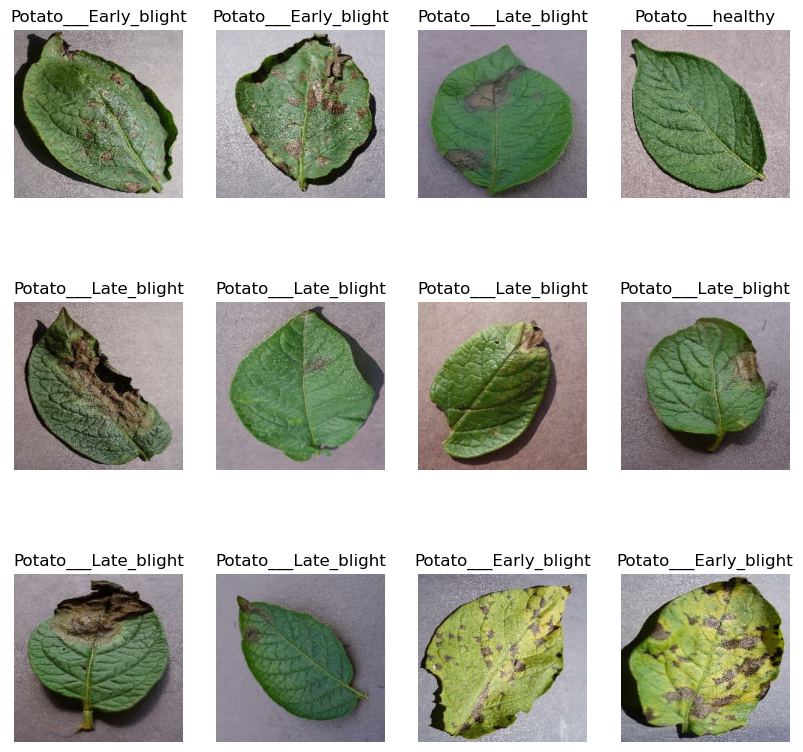

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):#take only one example
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
print(image_batch[0].shape)
print(label_batch.numpy())

(256, 256, 3)
[0 0 1 2 1 1 1 1 1 1 0 0 2 0 1 0 2 0 0 0 2 0 0 1 1 0 1 1 0 0 1 1]


In [23]:
# split the dataset into traing 80% and 20% for testing the dataset
epochs=20
channels=3
training_size=0.8
len(dataset)*training_size

54.400000000000006

In [24]:
train_dataset=dataset.take(54)
len(train_dataset)

54

In [25]:
test_dataset=dataset.skip(54)
len(test_dataset)

14

In [26]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [27]:
val_dataset=test_dataset.take(6)
len(val_dataset)

6

In [28]:
test_dataset=test_dataset.skip(6)
len(test_dataset)

8

In [29]:
def get_dataset(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [30]:
train_ds,val_ds,test_ds=get_dataset(dataset)

In [31]:
len(train_ds)

54

In [32]:
#it will keep the image in the memory for next use
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
#/255 so that the img is 0 or 1
rescale_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
#data agumentation, preprocessing
data_agumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [35]:
#model building using CNN
input_shape=(batch_size,image_size,image_size,channels)
n_class=3
model=models.Sequential([
    rescale_resize,data_agumentation,layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(64, (3,3),activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(64, (3,3),activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(64, (3,3),activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Flatten(),
                    layers.Dense(64,activation='relu'),
                    layers.Dense(n_class,activation='softmax'),
])
model.build(input_shape=input_shape)


In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [37]:
model.compile(
optimizer=Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [38]:
history=model.fit(train_ds,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=val_ds)

Epoch 1/20


54/54 [==============================] - 225s 4s/step - loss: 0.8575 - accuracy: 0.5174 - val_loss: 0.6880 - val_accuracy: 0.7083
Epoch 2/20
54/54 [==============================] - 213s 4s/step - loss: 0.4892 - accuracy: 0.7946 - val_loss: 0.4516 - val_accuracy: 0.8073
Epoch 3/20
54/54 [==============================] - 188s 3s/step - loss: 0.2846 - accuracy: 0.8924 - val_loss: 0.4309 - val_accuracy: 0.7969
Epoch 4/20
54/54 [==============================] - 205s 4s/step - loss: 0.2385 - accuracy: 0.9132 - val_loss: 0.4277 - val_accuracy: 0.7917
Epoch 5/20
54/54 [==============================] - 208s 4s/step - loss: 0.1460 - accuracy: 0.9456 - val_loss: 0.2348 - val_accuracy: 0.8854
Epoch 6/20
54/54 [==============================] - 197s 4s/step - loss: 0.1018 - accuracy: 0.9653 - val_loss: 0.5030 - val_accuracy: 0.8177
Epoch 7/20
54/54 [==============================] - 134s 2s/step - loss: 0.1058 - accuracy: 0.9606 - val_loss: 0.0982 - val_accuracy: 0.9635
Epoch 8/20


In [39]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 250ms/step - loss: 0.0119 - accuracy: 1.0000


In [40]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
loss=history.history['loss']

First image
Class label is: Potato___healthy
1/1 [==============================] - 0s 483ms/step
Prediction value is: Potato___healthy


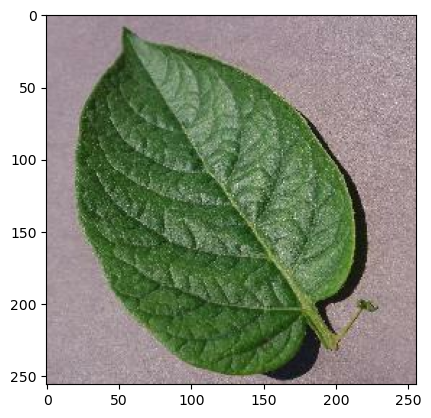

In [43]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print('First image' )
    plt.imshow(first_image)
    print("Class label is:",class_names[first_label])
    
    prediction_model=model.predict(image_batch)
    print("Prediction value is:",class_names[np.argmax(prediction_model[0])])
    

In [44]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 31ms/step


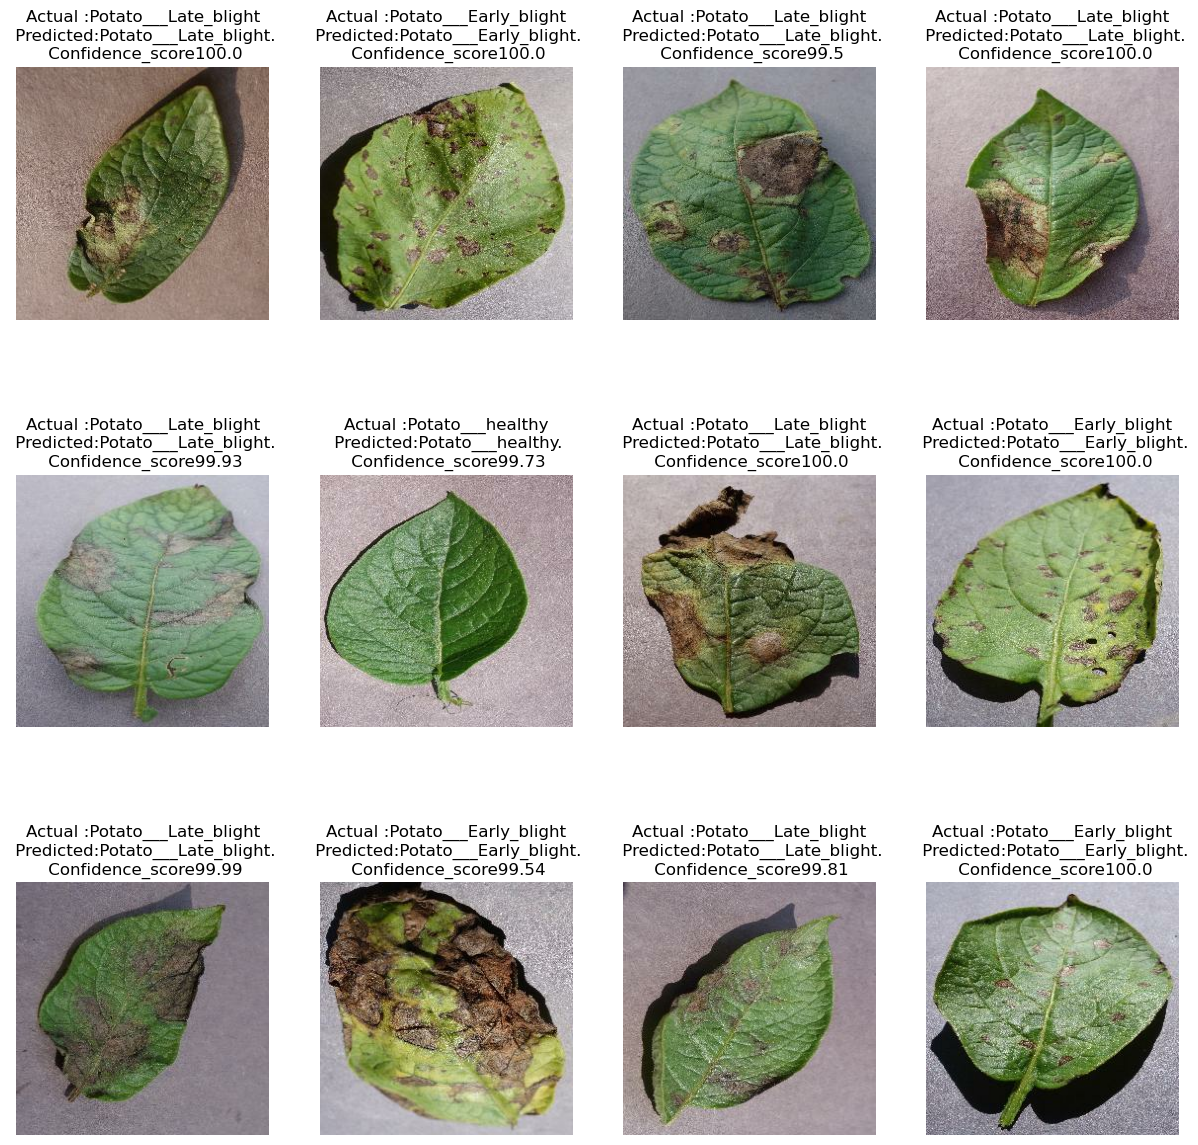

In [45]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):#take only one example
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual :{actual_class}\n Predicted:{predicted_class}.\n Confidence_score{confidence}")
        plt.axis('off')

In [46]:
model_version=2
model.save(f'../models/{model_version}')
import os
os.listdir('../models')

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


['2']

In [47]:
model.save("models.h5")

C:\Users\Vishnu Kumar\Downloads\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
